<a href="https://colab.research.google.com/github/Phantom76819/IT5100F-Project/blob/main/IT5100F_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Xu Yiwei: A0268379H

# Task 1: Problem Definition

Calculating the actual sale price of an HDB resale flat in Singapore involves considering numerous variables, such as the flat's location, neighboring developments, the number of rooms, nearby elementary schools, etc.

In this project, we will explore the trend of HDB prices in recent years, and try to explore what are the key factors that drive resale prices.

# Task 2: Data collection/curation

We will use the HDB Resale Flat Prices dataset from (https://beta.data.gov.sg/collections/189/datasets/d_ebc5ab87086db484f88045b47411ebc5/view).

The Resale Flat Prices dataset, capturing transactions registered from January 2017 onwards, provides a comprehensive overview of resale activities. By utilizing the zipcode information,  Additionally, incorporating data on nearby MRT and LRT stations along with primary schools will allow us to examine their influence on resale prices and explore potential correlations.

The existing dataset only has block and street name which is not granular enough
For a better regression, we will convert addresses columns into a numeric column using Singapore Zipcode Mapper (https://www.kaggle.com/datasets/mylee2009/singapore-postal-code-mapper), facilitating more straightforward data analysis.

Additionally, incorporating data on nearby MRT and LRT stations along with primary schools will allow us to examine their influence on resale prices and explore potential correlations. (https://www.kaggle.com/datasets/yxlee245/singapore-train-station-coordinates, https://schoolbell.sg/primary-school-ranking/)


In [ ]:
# Load data from either Google drive or local folder
import pandas as pd

# Colab
from google.colab import drive
drive.mount('/content/drive')
hdb_df = pd.read_csv('/content/drive/MyDrive/IT5100F/ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv')
mrt_df = pd.read_csv('/content/drive/MyDrive/IT5100F/mrt_lrt_data.csv')
sch_df = pd.read_csv('/content/drive/MyDrive/IT5100F/primary_school_data.csv')
zip_code = pd.read_csv('/content/drive/MyDrive/IT5100F/sg_zipcode_mapper.csv', encoding='latin-1')

# Local machine
# hdb_df = pd.read_csv('ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv')
# mrt_df = pd.read_csv('mrt_lrt_data.csv')
# sch_df = pd.read_csv('primary_school_data.csv')
# zip_code = pd.read_csv('sg_zipcode_mapper.csv', encoding='latin-1')

datasets = [hdb_df, mrt_df, sch_df, zip_code]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Task 3: Data preparation



> Install necessary packages

!pip install pandas

!pip install numpy

!pip install matplotlib

!pip install scikit-learn

!pip install seaborn

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import haversine_distances

## Examine data

In [ ]:
hdb_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


In [ ]:
mrt_df.head()

,station_name,type,lat,lng
0,Jurong East,MRT,1.333207,103.742308
1,Bukit Batok,MRT,1.349069,103.749596
2,Bukit Gombak,MRT,1.359043,103.751863
3,Choa Chu Kang,MRT,1.385417,103.744316
4,Yew Tee,MRT,1.397383,103.747523


In [ ]:
sch_df.head()

,school_name,lat,lng
0,Rosyth School,1.37319,103.87468
1,Nanyang Primary School,1.32126,103.80767
2,Catholic High School (Primary Section),1.35487,103.84516
3,Nan Hua Primary School,1.32005,103.76192
4,Tao Nan School,1.30508,103.91149


In [ ]:
zip_code.head()

,postal,latitude,longtitude,searchval,blk_no,road_name,building,address,postal.1
0,398614,1.312763,103.883519,# 1 LOFT,1,LORONG 24 GEYLANG,# 1 LOFT,1 LORONG 24 GEYLANG # 1 LOFT SINGAPORE 398614,398614
1,398721,1.312390,103.881504,# 1 SUITES,1,LORONG 20 GEYLANG,# 1 SUITES,1 LORONG 20 GEYLANG # 1 SUITES SINGAPORE 398721,398721
2,629875,1.309135,103.679463,1 BENOI ROAD SINGAPORE 629875,1,BENOI ROAD,NIL,1 BENOI ROAD SINGAPORE 629875,629875
3,439731,1.305466,103.895674,1 BOSCOMBE ROAD SINGAPORE 439731,1,BOSCOMBE ROAD,NIL,1 BOSCOMBE ROAD SINGAPORE 439731,439731
4,659592,1.344619,103.749789,1 BUKIT BATOK STREET 22 SINGAPORE 659592,1,BUKIT BATOK STREET 22,NIL,1 BUKIT BATOK STREET 22 SINGAPORE 659592,659592


In [ ]:
# Check for nans
for df in datasets:
    print(df.isna().sum())

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
dtype: int64
station_name    0
type            0
lat             0
lng             0
dtype: int64
school_name    0
lat            0
lng            0
dtype: int64
postal        0
latitude      0
longtitude    0
searchval     0
blk_no        0
road_name     0
building      0
address       0
postal.1      0
dtype: int64


In [ ]:
# Check for duplicates
for df in datasets:
    print(df.duplicated().sum())

284
0
0
0


In [ ]:
hdb_df.drop_duplicates(
    subset=['month','town','flat_type','block','street_name','storey_range','floor_area_sqm','flat_model','lease_commence_date','remaining_lease','resale_price'],
    inplace=True
    )

## Combine data

### Zip codes

In [ ]:
# Combine zip code data
zip_code = zip_code.rename({"road_name":"street_name","latitude":"lat","longtitude":"lng"}, axis=1)
zip_code['full_street_name'] = zip_code['blk_no']+' '+zip_code['street_name']
zip_code.drop(['postal'], axis=1, inplace=True)
zip_code.rename(columns = {'postal.1':'postal'}, inplace=True)
zip_code.drop_duplicates(subset=['postal'],inplace=True)
zip_code.drop_duplicates(subset=['full_street_name'],inplace=True)
zip_code.head()

,lat,lng,searchval,blk_no,street_name,building,address,postal,full_street_name
0,1.312763,103.883519,# 1 LOFT,1,LORONG 24 GEYLANG,# 1 LOFT,1 LORONG 24 GEYLANG # 1 LOFT SINGAPORE 398614,398614,1 LORONG 24 GEYLANG
1,1.312390,103.881504,# 1 SUITES,1,LORONG 20 GEYLANG,# 1 SUITES,1 LORONG 20 GEYLANG # 1 SUITES SINGAPORE 398721,398721,1 LORONG 20 GEYLANG
2,1.309135,103.679463,1 BENOI ROAD SINGAPORE 629875,1,BENOI ROAD,NIL,1 BENOI ROAD SINGAPORE 629875,629875,1 BENOI ROAD
3,1.305466,103.895674,1 BOSCOMBE ROAD SINGAPORE 439731,1,BOSCOMBE ROAD,NIL,1 BOSCOMBE ROAD SINGAPORE 439731,439731,1 BOSCOMBE ROAD
4,1.344619,103.749789,1 BUKIT BATOK STREET 22 SINGAPORE 659592,1,BUKIT BATOK STREET 22,NIL,1 BUKIT BATOK STREET 22 SINGAPORE 659592,659592,1 BUKIT BATOK STREET 22


In [ ]:
# Data cleaning to standardize some similar words between the street names used in df and zip_code
replacers= {
    'AVE':'AVENUE',
    'RD' : 'ROAD',
    'NTH' : 'NORTH',
    'ST' : 'STREET',
    'LOR' : 'LORONG',
    'DR' : 'DRIVE',
    'HTS' : 'HEIGHTS',
    'JLN' : 'JALAN',
    'TER' : 'TERRACE',
    'BT' : 'BUKIT',
    'PK' : 'PARK',
    'CRES' : 'CRESCENT',
    'GDNS' : 'GARDENS',
    'CTRL' : 'CENTRAL',
    'C\'WEALTH' : 'COMMONWEALTH',
    'CL' : 'CLOSE',
    'UPP' : 'UPPER',
    'PL' : 'PLACE',
    'STH' : 'SOUTH',
    'ST.' : 'SAINT',
    'TG' : 'TANJONG',
    'KG' : 'KAMPONG',
    'MKT' : 'MARKET'
}
hdb_df['street_name'] = hdb_df['street_name'].apply(lambda x: ' '.join([replacers[word] if word in replacers else word for word in x.split()]))
hdb_df['full_street_name'] = hdb_df['block']+' '+ hdb_df['street_name']
hdb_df = hdb_df.merge(zip_code[['full_street_name','postal', 'lat', 'lng']],on='full_street_name',how='left')
hdb_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,full_street_name,postal,lat,lng
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVENUE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,406 ANG MO KIO AVENUE 10,560406.0,1.362005,103.853880
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVENUE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,108 ANG MO KIO AVENUE 4,560108.0,1.370966,103.838202
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVENUE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0,602 ANG MO KIO AVENUE 5,560602.0,1.380709,103.835368
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVENUE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0,465 ANG MO KIO AVENUE 10,560465.0,1.366201,103.857201
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVENUE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0,601 ANG MO KIO AVENUE 5,560601.0,1.381041,103.835132


In [ ]:
# Impute missing postal codes based on street_name
hdb_df[['postal']] = hdb_df[['postal']].fillna(
    hdb_df.groupby('street_name').ffill()
)
# Impute missing lat/lng based on postal code
hdb_df[['lat']] = hdb_df[['lat']].fillna(
    hdb_df.groupby('postal').ffill()
)
hdb_df[['lng']] = hdb_df[['lng']].fillna(
    hdb_df.groupby('postal').ffill()
)
hdb_df.isna().sum()

month                   0
town                    0
flat_type               0
block                   0
street_name             0
storey_range            0
floor_area_sqm          0
flat_model              0
lease_commence_date     0
remaining_lease         0
resale_price            0
full_street_name        0
postal                 50
lat                    50
lng                    50
dtype: int64

In [ ]:
# Only 50 records having missing postal code, just drop them since we have a much larger data set
hdb_df.dropna(subset=['postal'],inplace=True)
hdb_df.reset_index(drop=True, inplace=True)
len(hdb_df)

177238

### Nearby MRT stations

In [ ]:
# Compute distances between HDB flats and MRTs
mrt_distance_matrix = haversine_distances(
    np.deg2rad(hdb_df[['lat', 'lng']].to_numpy()),  # convert lat/lng degrees to radians
    np.deg2rad(mrt_df[['lat', 'lng']].to_numpy())
    ) * 6371                                        # multiply by Earth's radius in km
hdb_df['nearest_mrt'] = [mrt_df.iloc[i]['station_name'] for i in mrt_distance_matrix.argmin(axis=1)]  # get closest mrt index
hdb_df['mrt_distance'] = mrt_distance_matrix.min(axis=1)

In [ ]:
hdb_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,full_street_name,postal,lat,lng,nearest_mrt,mrt_distance
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVENUE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,406 ANG MO KIO AVENUE 10,560406.0,1.362005,103.853880,Ang Mo Kio,1.011433
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVENUE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,108 ANG MO KIO AVENUE 4,560108.0,1.370966,103.838202,Ang Mo Kio,1.270031
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVENUE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0,602 ANG MO KIO AVENUE 5,560602.0,1.380709,103.835368,Yio Chu Kang,1.068607
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVENUE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0,465 ANG MO KIO AVENUE 10,560465.0,1.366201,103.857201,Ang Mo Kio,0.947097
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVENUE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0,601 ANG MO KIO AVENUE 5,560601.0,1.381041,103.835132,Yio Chu Kang,1.091392


### Nearby primary schools

In [ ]:
sch_distance_matrix = haversine_distances(
    np.deg2rad(hdb_df[['lat', 'lng']].to_numpy()),    # convert lat/lng degrees to radians
    np.deg2rad(sch_df[['lat', 'lng']].to_numpy())
    ) * 6371                                          # multiply by Earth's radius in km
num_of_prestigious_sch_nearby = []
prestigious_schools = []
for i in range(len(sch_distance_matrix)):
    if np.sum(sch_distance_matrix[i] < 1) > 0:   # check for schools < 1km away
        num_of_prestigious_sch_nearby.append(np.sum(sch_distance_matrix[i] < 1))
        nearby_schools = [sch_df.iloc[j[0]]['school_name'] for j in np.argwhere(sch_distance_matrix[i] < 1)]
        prestigious_schools.append(nearby_schools)
    else:
        num_of_prestigious_sch_nearby.append(0)
        prestigious_schools.append([])
hdb_df['num_of_prestigious_sch_nearby'] = num_of_prestigious_sch_nearby
hdb_df['prestigious_schools'] = prestigious_schools

In [ ]:
hdb_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,full_street_name,postal,lat,lng,nearest_mrt,mrt_distance,num_of_prestigious_sch_nearby,prestigious_schools
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVENUE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,406 ANG MO KIO AVENUE 10,560406.0,1.362005,103.853880,Ang Mo Kio,1.011433,0,[]
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVENUE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,108 ANG MO KIO AVENUE 4,560108.0,1.370966,103.838202,Ang Mo Kio,1.270031,1,[CHIJ St. Nicholas Girls' School (Primary Sect...
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVENUE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0,602 ANG MO KIO AVENUE 5,560602.0,1.380709,103.835368,Yio Chu Kang,1.068607,1,[CHIJ St. Nicholas Girls' School (Primary Sect...
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVENUE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0,465 ANG MO KIO AVENUE 10,560465.0,1.366201,103.857201,Ang Mo Kio,0.947097,0,[]
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVENUE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0,601 ANG MO KIO AVENUE 5,560601.0,1.381041,103.835132,Yio Chu Kang,1.091392,1,[CHIJ St. Nicholas Girls' School (Primary Sect...


## Feature engineering

In [ ]:
# Convert date types
hdb_df['month'] = pd.to_datetime(hdb_df['month'])
hdb_df['year'] = hdb_df['month'].dt.year
hdb_df['month'] = hdb_df['month'].dt.month

In [ ]:
# Add a new feature (remaining_lease) which should have an important impact on HDB resale prices
hdb_df['remaining_lease'] = 99 - (2024 - hdb_df['lease_commence_date'])

In [ ]:
hdb_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,full_street_name,postal,lat,lng,nearest_mrt,mrt_distance,num_of_prestigious_sch_nearby,prestigious_schools,year
0,1,ANG MO KIO,2 ROOM,406,ANG MO KIO AVENUE 10,10 TO 12,44.0,Improved,1979,54,232000.0,406 ANG MO KIO AVENUE 10,560406.0,1.362005,103.853880,Ang Mo Kio,1.011433,0,[],2017
1,1,ANG MO KIO,3 ROOM,108,ANG MO KIO AVENUE 4,01 TO 03,67.0,New Generation,1978,53,250000.0,108 ANG MO KIO AVENUE 4,560108.0,1.370966,103.838202,Ang Mo Kio,1.270031,1,[CHIJ St. Nicholas Girls' School (Primary Sect...,2017
2,1,ANG MO KIO,3 ROOM,602,ANG MO KIO AVENUE 5,01 TO 03,67.0,New Generation,1980,55,262000.0,602 ANG MO KIO AVENUE 5,560602.0,1.380709,103.835368,Yio Chu Kang,1.068607,1,[CHIJ St. Nicholas Girls' School (Primary Sect...,2017
3,1,ANG MO KIO,3 ROOM,465,ANG MO KIO AVENUE 10,04 TO 06,68.0,New Generation,1980,55,265000.0,465 ANG MO KIO AVENUE 10,560465.0,1.366201,103.857201,Ang Mo Kio,0.947097,0,[],2017
4,1,ANG MO KIO,3 ROOM,601,ANG MO KIO AVENUE 5,01 TO 03,67.0,New Generation,1980,55,265000.0,601 ANG MO KIO AVENUE 5,560601.0,1.381041,103.835132,Yio Chu Kang,1.091392,1,[CHIJ St. Nicholas Girls' School (Primary Sect...,2017


# Task 4: Exploratory data analysis and visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

numeric_features = ['year', 'month', 'floor_area_sqm', 'remaining_lease', 'resale_price', 'mrt_distance',
                    'num_of_prestigious_sch_nearby', 'postal', 'lat', 'lng']
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())  # Scale data
])

categorical_features = ['town', 'flat_type', 'street_name', 'storey_range', 'flat_model', 'nearest_mrt']
categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Convert categorical data
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Fit and transform the data
X_preprocessed = preprocessor.fit_transform(hdb_df)

# Apply PCA
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_preprocessed.toarray())
explained_variances = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

print(explained_variances)
print(pca.singular_values_)

[0.15218466 0.12618957 0.08623791 0.07710847 0.07333014 0.06269128
 0.05210327 0.04389404 0.0275742  0.01555137 0.01456067 0.01414653
 0.01301245 0.01222458 0.01162946 0.00982091 0.00719166 0.00701703
 0.00675413 0.00569264]
[641.07632276 583.76227847 482.58455683 456.32612924 445.00569308
 411.46023063 375.10838749 344.29210399 272.88254486 204.93146922
 198.29645007 195.45609235 187.4579361  181.69427349 177.21646818
 162.85463017 139.36023276 137.65785338 135.0544416  123.98844875]


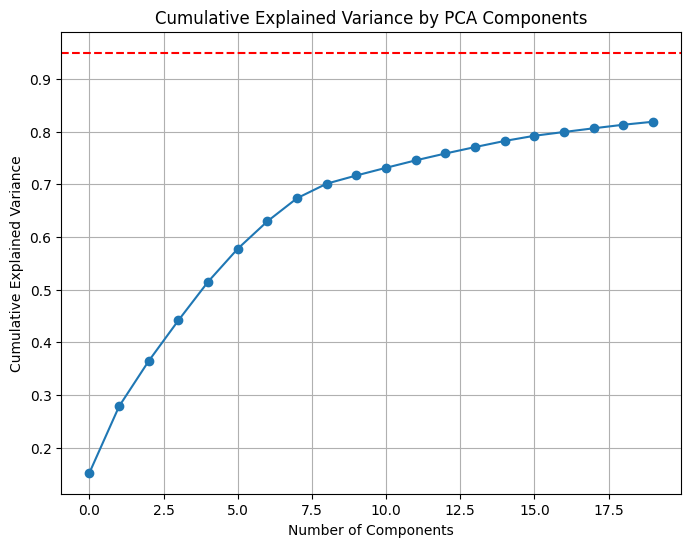

In [ ]:
#Plot pca results
plt.figure(figsize=(8, 6))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--')
plt.show()

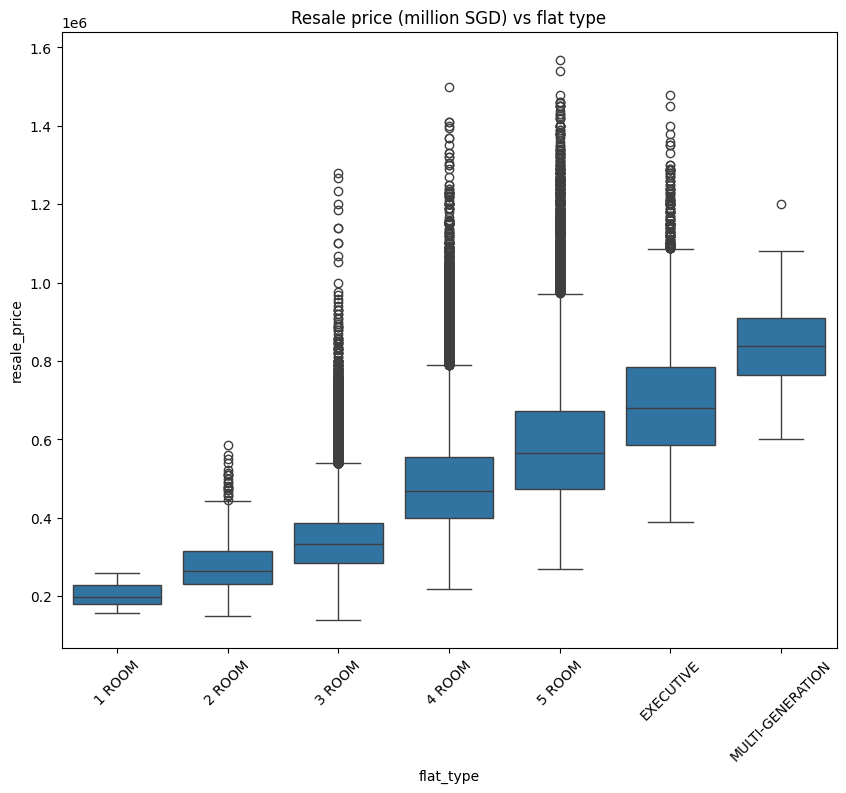

In [ ]:
# Resale price based on flat type
plt.figure(figsize=(10,8))
sns.boxplot(
    data=hdb_df, y='resale_price', x='flat_type',
    order=['1 ROOM', '2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', 'MULTI-GENERATION']
    )
plt.title("Resale price (million SGD) vs flat type")
plt.xticks(rotation=45)
plt.show()

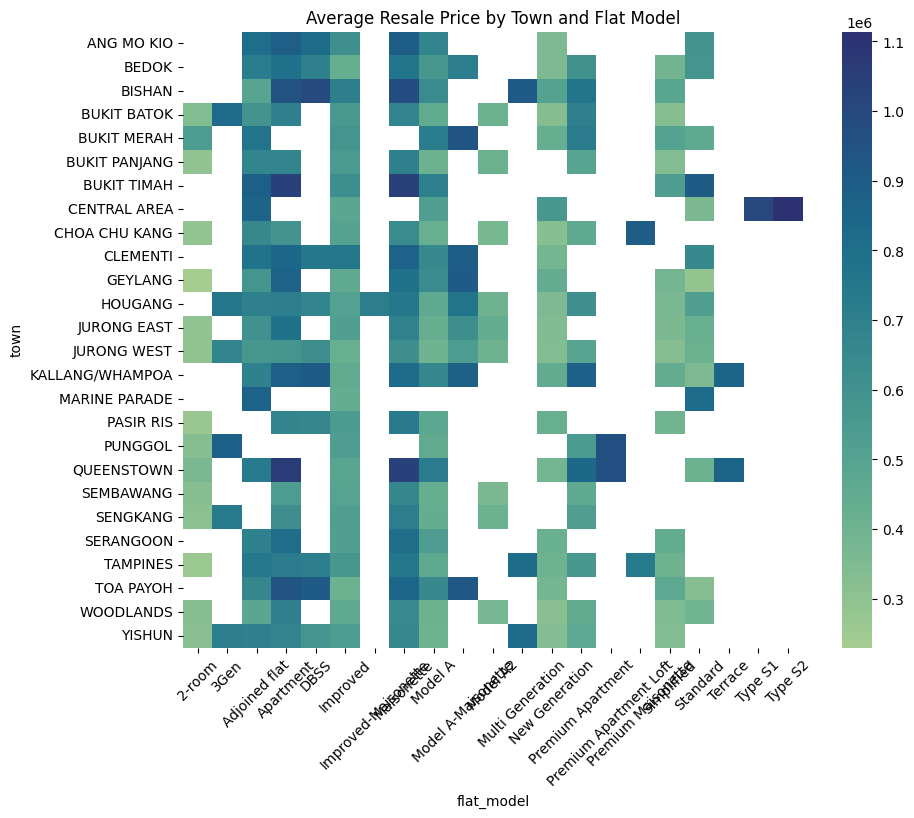

In [ ]:
# Resale price based on town and flat model
pivot_table = hdb_df.pivot_table(index='town', columns='flat_model', values='resale_price', aggfunc='mean')
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table,
            cmap='crest',  # Color map, can be adjusted based on preference
            fmt=".0f")
plt.title('Average Resale Price by Town and Flat Model')
plt.xticks(rotation=45)
plt.show()

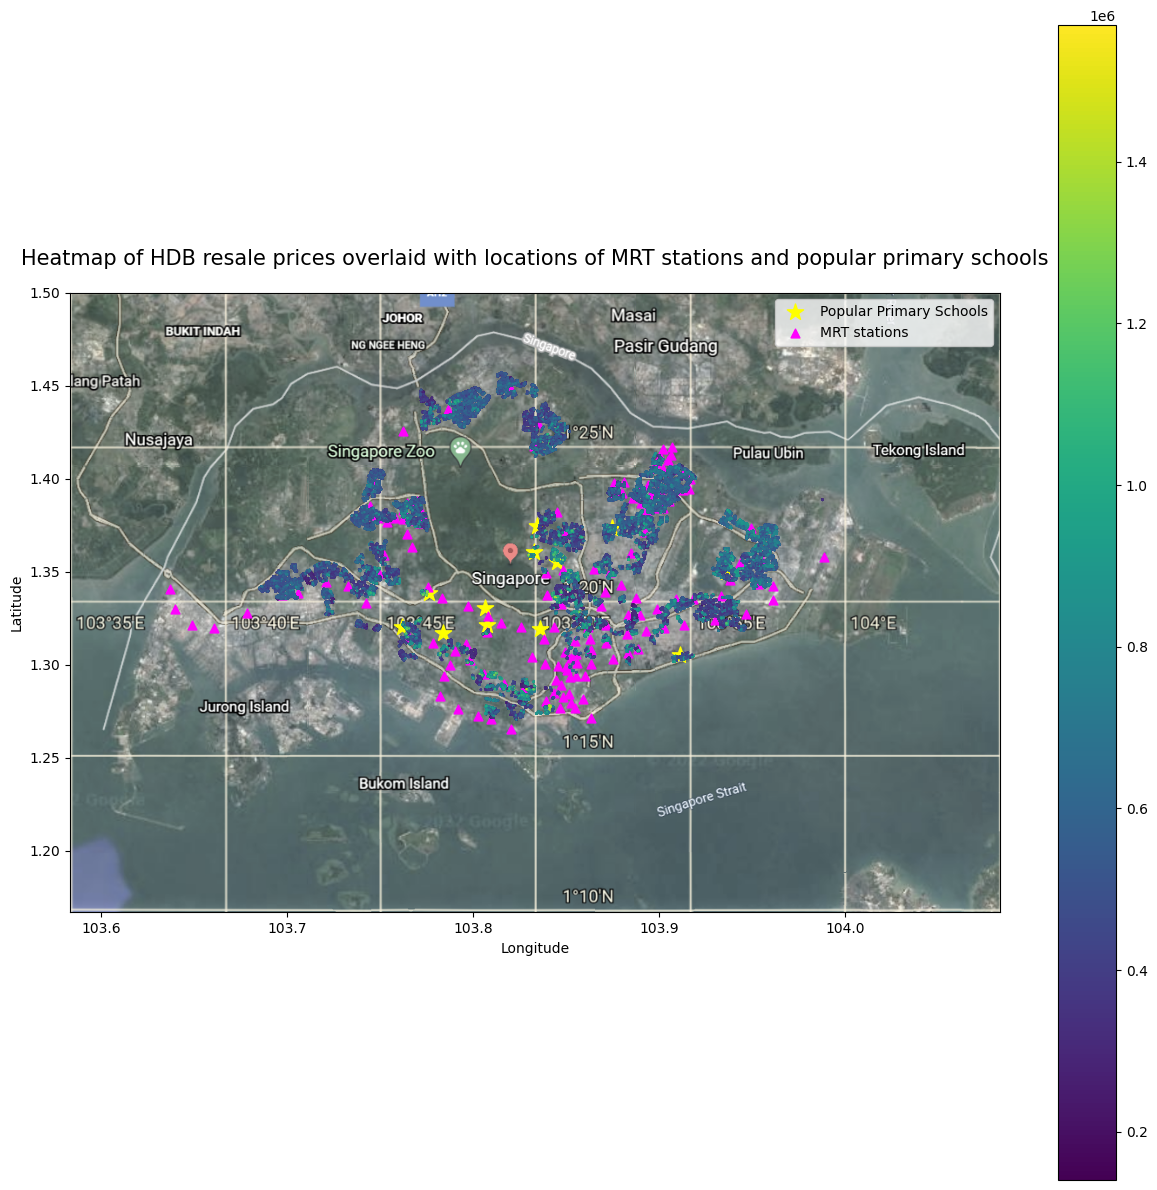

In [ ]:
# Resale price based on location with respect to MRT stations and prestigious primary schools
sg_map = plt.imread('/content/drive/MyDrive/IT5100F/Singapore_Map.png')

# Coordinates taken from Google Earth
BBox = [103.5833, 104.0833, 1.1667, 1.5]

# Plot heatmap
fig, ax = plt.subplots(figsize = (15,15))
plt.imshow(sg_map, extent=BBox, aspect="equal")
plt.scatter(sch_df.lng, sch_df.lat, s = 150, marker = '*', c = 'yellow', label = 'Popular Primary Schools')
plt.scatter(mrt_df.lng, mrt_df.lat, s = 40, marker = '^', c = 'magenta', label = 'MRT stations')
plt.scatter(hdb_df.lng, hdb_df.lat, c = hdb_df.resale_price, s=0.5)

plt.colorbar()
plt.title("Heatmap of HDB resale prices overlaid with locations of MRT stations and popular primary schools", fontsize=15, pad =20) # set title for entire plot
plt.ylabel("Latitude")
plt.xlabel("Longitude")
ax.legend()

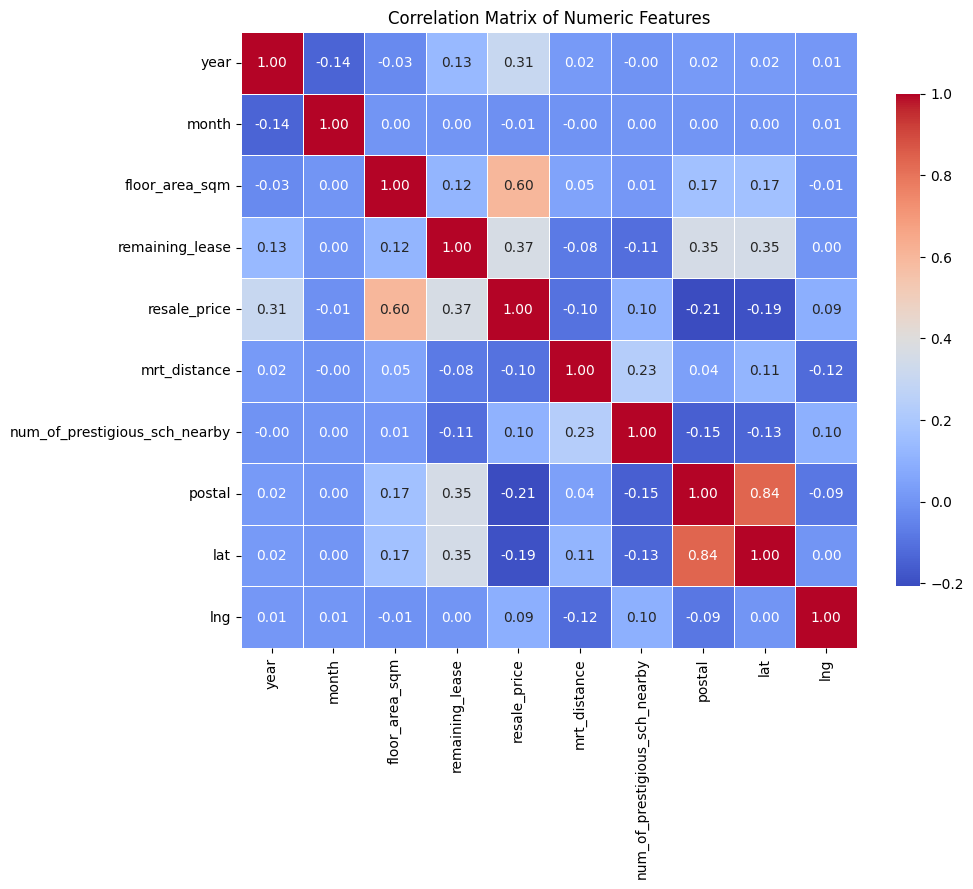

In [ ]:
# Calculate the correlation matrix for numeric features

hdb_df_numeric = hdb_df[numeric_features]
corr_matrix = hdb_df_numeric.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .8})

plt.title('Correlation Matrix of Numeric Features')
plt.show()

The following observations with regard to 'resale_price' are seen:
- 'resale_price' is positively correlated with the year of data published, indicating a potential increasing trend of HDB resale price over the years
- It is expected that the price is significantly postively correlated with the floor area (0.60) and remaining lease (0.37)
- While 'resale_price' is negatively correlated with the distance to MRT, -0.10 suggests the impact on price might not be that significant
- While postal code, latitude and longitude were originally expected of little numeric significance, the correlation matrix shows a somewhat negative correlation between the resale price, and postal code and latitude

We then examine how the postal code is arranged. It is found out that interestingly, smaller postal code represent more central / better locations to a certain extent (https://lengandalbertproperty.com/singapore-district-code-and-district-map/). Therefore, it is a sensible observation that the larger the postal code (and thus less optimal the location), the lower the price is.

Similarly, the latitude of the unit has a negative correlation with the resale price, which makes sense as the central business district is at the south of Singapore. Areas like Woodlands, Admiralty or Sembawang are relatively newer and less developed, leading to cheaper prices.

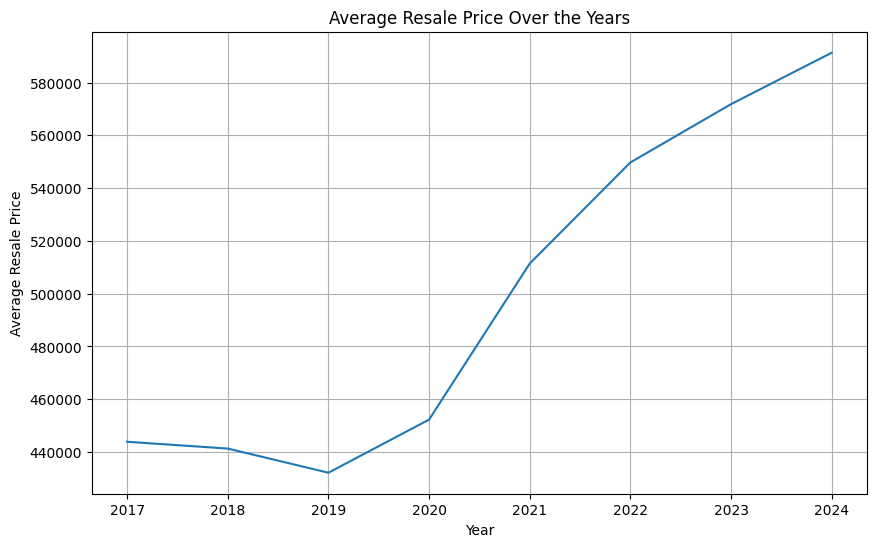

In [ ]:
# Average resale price by year
yearly_price = hdb_df.groupby('year')['resale_price'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(data=yearly_price)
plt.title('Average Resale Price Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Resale Price')
plt.grid(True)
plt.show()

The given data year range is between 2017 and 2024
It has been noticed that:
- Overall, the price shows an increasing trend although there is a dip in year 2019
- The price is relatively stable before 2020, before starts increasing more significantly from 2020 onwards
- In order to see the extent of increase more clearly, we plot the % increase in average price by year next.

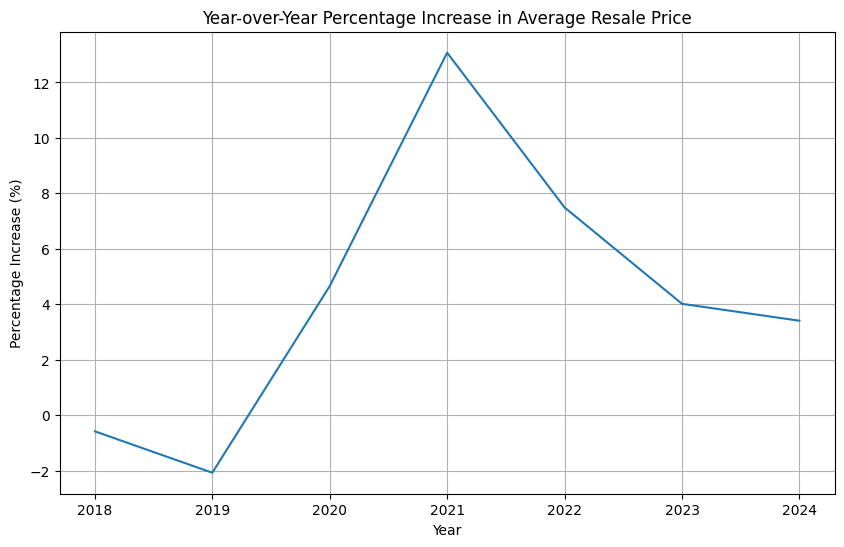

In [ ]:
# Calculate the year-over-year percentage change in average resale price
yearly_price_pct_change = yearly_price.pct_change() * 100  # multiply by 100 to convert to percentage

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(data=yearly_price_pct_change)
plt.title('Year-over-Year Percentage Increase in Average Resale Price')
plt.xlabel('Year')
plt.ylabel('Percentage Increase (%)')
plt.grid(True)
plt.show()

Year 2021 observes the highest resale price increase of about 13% on average. While price still increases after 2021, the speed of increase has been decreasing to the latest ~4% in 2024.

We believe the reasons for the above observations are as follows:
1. COVID-19 Impact: The outbreak of COVID-19 led to a temporary suspension of construction activities, which delayed the completion of new Build-To-Order (BTO) flats. Many homebuyers, unable to wait for new flats, turned to the resale market, pushing up demand and prices. (https://www.channelnewsasia.com/singapore/record-high-hdb-resale-price-q3-2021-2215726)​.
2. Low Interest Rates: During this period, interest rates were at historic lows in Singapore. This made loans more affordable, allowing more people to borrow money cheaply to buy homes, which increased demand in the housing market and pushed up resale prices. (https://www.channelnewsasia.com/singapore/hdb-flat-resale-price-index-rpi-2022-sales-volume-bto-3179506)
3. Government Measures: In response to the rapid price increase, the Singapore government introduced measures intended to cool down the housing market. These measures were designed to temper the market by making it slightly more difficult to purchase resale flats, thus dampening the overheated demand. (https://www.channelnewsasia.com/singapore/record-high-hdb-resale-price-q3-2021-2215726)

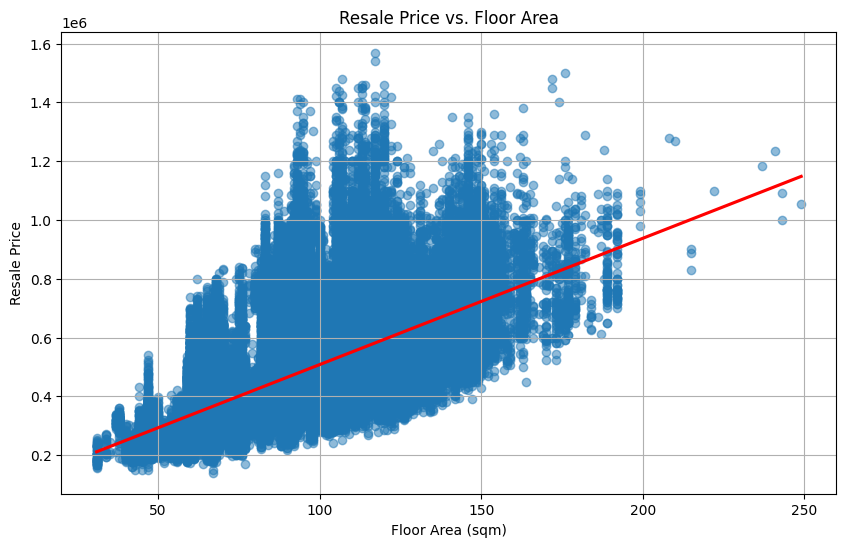

In [ ]:
# Scatter plot of resale price by floor area
plt.figure(figsize=(10, 6))
sns.regplot(x='floor_area_sqm', y='resale_price', data=hdb_df,
            scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.title('Resale Price vs. Floor Area')
plt.xlabel('Floor Area (sqm)')
plt.ylabel('Resale Price')
plt.grid(True)
plt.show()

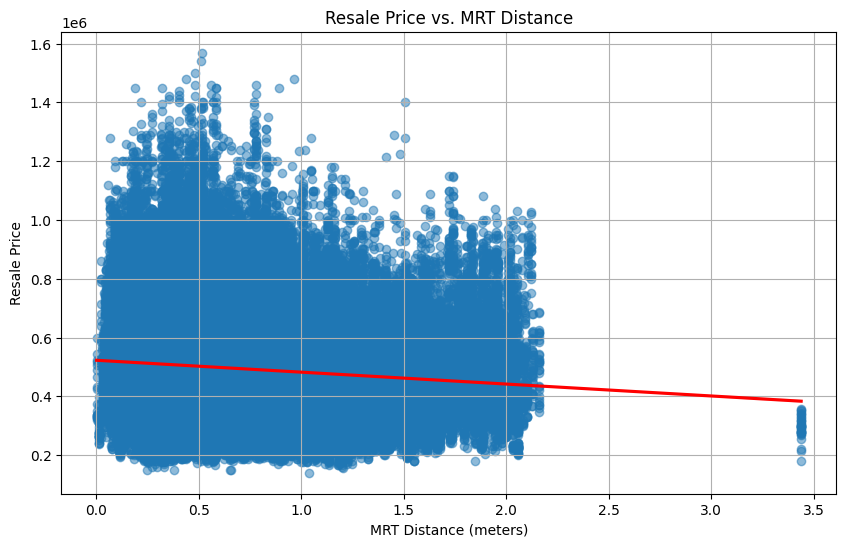

In [ ]:
# Scatter plot of resale price by distance to MRT
plt.figure(figsize=(10, 6))
sns.regplot(x='mrt_distance', y='resale_price', data=hdb_df,
            scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Resale Price vs. MRT Distance')
plt.xlabel('MRT Distance (meters)')
plt.ylabel('Resale Price')
plt.grid(True)
plt.show()

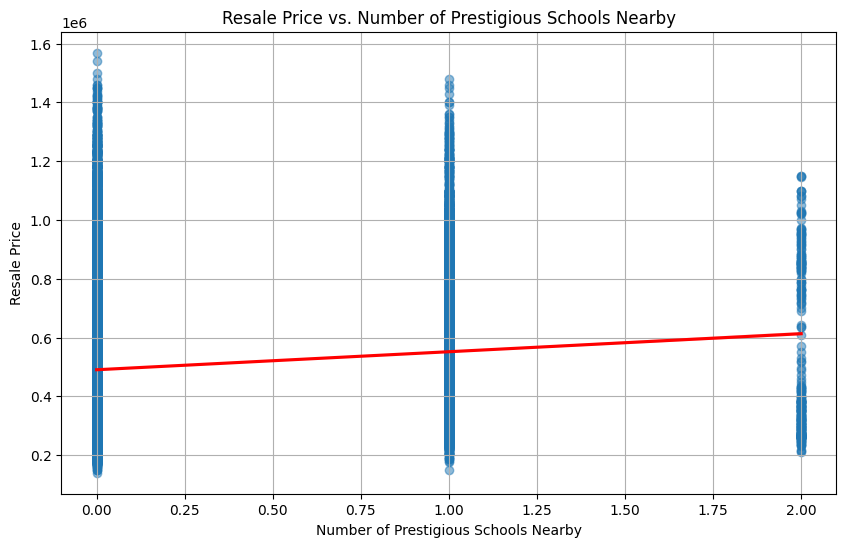

In [ ]:
# Scatter plot of resale price by number of Prestigious Schools Nearby
plt.figure(figsize=(10, 6))
sns.regplot(x='num_of_prestigious_sch_nearby', y='resale_price', data=hdb_df,
            scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Resale Price vs. Number of Prestigious Schools Nearby')
plt.xlabel('Number of Prestigious Schools Nearby')
plt.ylabel('Resale Price')
plt.grid(True)
plt.show()

# Task 5: Modeling and visualization

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [ ]:
# Split dataset
final_df = hdb_df.copy()
y = final_df['resale_price']
X = final_df.drop(['resale_price', 'prestigious_schools'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Scale numeric features and one-hot encode categorical features
numeric_features = ['year', 'month', 'floor_area_sqm', 'remaining_lease', 'mrt_distance',
                    'num_of_prestigious_sch_nearby', 'postal', 'lat', 'lng']
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())  # Scale data
])

categorical_features = ['town', 'flat_type', 'street_name', 'storey_range', 'flat_model', 'nearest_mrt']
categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Convert categorical data
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [ ]:
# Fit linear regression model
reg = LinearRegression()
reg.fit(X_train_processed, y_train)
y_pred_lr = reg.predict(X_test_processed)
print(reg.score(X_test_processed, y_test))

0.918091505112588


In [ ]:
# Get top 10 features
top_features_indices = np.argsort(reg.coef_)[-10:]
features = preprocessor.get_feature_names_out()
for i in top_features_indices:
  print('Feature: ', features[i])
  print('LR coefficient: ', reg.coef_[i])
  print()

Feature:  cat__street_name_TAO CHING ROAD
LR coefficient:  149638.82146927464

Feature:  cat__street_name_MOULMEIN ROAD
LR coefficient:  160170.337856768

Feature:  cat__street_name_TIONG BAHRU ROAD
LR coefficient:  168437.8206141717

Feature:  cat__street_name_LIM LIAK STREET
LR coefficient:  173603.2411263135

Feature:  cat__street_name_MOH GUAN TERRACE
LR coefficient:  197020.00815319712

Feature:  cat__street_name_KIM CHENG STREET
LR coefficient:  197961.43058493992

Feature:  cat__town_BISHAN
LR coefficient:  207292.61392535997

Feature:  cat__street_name_KIM PONG ROAD
LR coefficient:  210903.43966714022

Feature:  cat__street_name_ZION ROAD
LR coefficient:  212380.09670158316

Feature:  cat__flat_model_Terrace
LR coefficient:  367502.98277491523



The linear regression model was able to fit well and achieved a R^2 score of 91.8. Based on the top 10 coefficients, the most important feature determining HDB resale prices is location.

# Task 6: Report insights and conclusions